In [1]:
# load libraries
import pandas as pd
import numpy as np

np.random.seed(1337) # LDiA relies on a random number generator; this keeps things constant

import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.tokenize.casual import casual_tokenize            # tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer  # put it back together

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
# the goal of this exercise is to create a model with the highest interpretability without sacrificing too much accuracy.
# so use alphanumeric and punctuation only for tokens
# clean out as much crap as possible from tokens
# then do trigrams for tfidf, and inspect
# then do ldia for topics, and inspect
# then do classification with lda, and logistic regression for a quick check

# Step 1: Get Data

The goal of this exercise is to create a model with the highest interpretability witout sacrificing too much accuracy.
So, I will first load the data and then remove everything that isn't alphanumeric.

In [3]:
src_dir = r'C:\Users\groov\PythonCode\output\trump_tweets\\'
hostile_file = src_dir + 'trump_tweets_hostile_clf.csv'
detokenizer = TreebankWordDetokenizer()

clf_df = pd.read_csv(hostile_file, header=None)
clf_df.columns = ['ts', 'tweet', 'label']
clf_df.drop('ts', axis=1, inplace=True)
clf_df.reset_index(drop=True, inplace=True)

# wrangling
clf_df['tweet'] = clf_df['tweet'].str.replace('&amp;', 'and')

# keep only alphanum
clf_df['tokens'] = clf_df['tweet'].apply(casual_tokenize)
#clf_df['tokens'] = clf_df['tokens'].apply(lambda tokens: [token for token in tokens if token.isalnum()])
clf_df['tweet'] = clf_df['tokens'].apply(detokenizer.detokenize)

# extract
word_list = sorted(set(clf_df['tokens'].sum()))

# clean up
clf_df.drop('tokens', axis=1, inplace=True)

clf_df.head()

,tweet,label
0,no matter what you do for the do nothing democ...,1
1,"them happy, or even a little bit satisfied . t...",1
2,the most often used phrase in the lamestream m...,1
3,just like i was right on ventilators (our coun...,0
4,. @foxnews “ dems say president trump is tryin...,0


Let's also prepare some stopwords that we can experiment with.

In [4]:
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

stop_words = set(stopwords.words('english'))
combined_stop_words = set(list(stop_words) + list(STOP_WORDS))

And let's set aside the data for tfidf and bow.

In [5]:
tweets = clf_df['tweet']
labels = clf_df['label']

# Step 2: Bag of Words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer(tokenizer=casual_tokenize, ngram_range=(1,3))

In [7]:
bow_docs = pd.DataFrame(counter.fit_transform(clf_df['tweet'].values).toarray())
column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys())))
bow_docs.columns = terms
bow_docs.head()

,!,! !,! ! !,! ! @generalmotors,! ! and,! ! ford,! #2020,! #2020election,! #killthevirus,! #maga,...,” witnesses,"” witnesses ,",” would,” would always,” wrong,” wrong !,” –,” – available,…,… .
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# let's look for highest counts by class
bow_df = bow_docs.merge(labels, left_index=True, right_index=True)
bow_df.head()

,!,! !,! ! !,! ! @generalmotors,! ! and,! ! ford,! #2020,! #2020election,! #killthevirus,! #maga,...,"” witnesses ,",” would,” would always,” wrong,” wrong !,” –,” – available,…,… .,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
bow_df_agg = bow_df.groupby('label').sum().T

In [10]:
bow_df_agg[1].sort_values(ascending=False)[0:100].index

Index([',', 'the', '.', 'and', 'to', '!', 'a', '’', 'is', 'of', 'in', 'that',
       'i', 'for', 'it', 'they', ', and', 't', '’ t', '”', 'are', '“', 'be',
       'on', 'he', 'was', 'do', 's', 'with', 'have', 'nothing', '?', '’ s',
       'will', 'democrats', '(', 'this', ')', 'fake', 'not', 'of the', 'news',
       'no', 'impeachment', 'in the', 'all', 'just', 'you', 'now', 'fake news',
       'so', 'who', 'very', 'president', 'their', 'has', 'do nothing', 'but',
       'by', 'people', 'hoax', 'our', 'or', 'as', 'his', 'me', 'we', 'up',
       'even', 'should', 'schiff', 'never', 'democrat', 'she', 'great',
       ', the', 'out', 'would', 'what', 'want', '. they', 'pelosi', 'my',
       'do nothing democrats', 'don', 'nothing democrats', 'left', 'don ’',
       'house', 'more', 'don ’ t', 'media', 'impeachment hoax', 'when', 'like',
       ', but', 'to the', 'corrupt', 'him', '. the'],
      dtype='object')

In [11]:
bow_df_agg[0].sort_values(ascending=False)[0:100].index

Index(['.', ',', 'the', 'and', '!', 'to', 'of', 'a', 'in', 'will', 'is', 'for',
       'our', 'great', 'be', 'i', 'on', ', and', 'we', 'with', 'that', 'are',
       'you', 'it', 'have', '’', 'will be', 'very', 'has', 'at', 'of the',
       'this', 's', 'they', 'thank', 'by', 'all', 'he', 'thank you', '(', '”',
       'in the', 'my', ')', 'new', 'not', 'as', 'was', '. we', '“', 'big',
       'people', '’ s', 'your', 'president', 'from', 'states', 'get', 'but',
       'now', '%', 'been', '. thank you', 'house', '. thank', ', the',
       'for the', 'just', 'and the', 'many', 'country', 'so', 'up', 'you !',
       'to the', 'out', 'more', 'united', '. i', 'm', 'good', 'thank you !',
       'their', '. he', 'today', 'news', 'a great', 'm .', 'done', 'who',
       '. m .', '. m', 'white', 'strong', 'we are', 'p', 'white house', 'do',
       'china', 'i will'],
      dtype='object')

# Step 2: TF-IDF Vectorize

Next, I'm going to use the cleaned up text and create tf-idf vectors for tokens, bigrams, and trigrams. I'll confirm this still looks good by doing basic tf-idf analysis by label. I am not going to remove stopwords, as they often contain information. For
instance, one common slur is "do nothing democrats", and the word "do" is a stopword. 

In [24]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=(1,3), lowercase=True, sublinear_tf=True)

tfidf_docs = tfidf.fit_transform(raw_documents=tweets)

tfidf_docs

<1432x76161 sparse matrix of type '<class 'numpy.float64'>'
	with 162691 stored elements in Compressed Sparse Row format>

In [25]:
tfidf_df = pd.DataFrame(tfidf_docs.todense(), columns=tfidf.vocabulary_)
tfidf_df = tfidf_df.merge(labels, left_index=True, right_index=True)

tfidf_df.head()

,no,matter,what,you,do,for,the,nothing,democrats,",",...,it was plenty,was plenty .,plenty . state,. state should,state should have,have had them,had them in,them in stockpile,in stockpile !,label
0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.033956,0.11912,0.072739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.015474,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.026820,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.015063,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [26]:
tfidf_df_agg = tfidf_df.groupby('label').mean()
tfidf_df_agg

,no,matter,what,you,do,for,the,nothing,democrats,",",...,and it was,it was plenty,was plenty .,plenty . state,. state should,state should have,have had them,had them in,them in stockpile,in stockpile !
label,,,,,,,,,,,,,,,,,,,,,
0,0.020619,0.001399,0.000738,0.000000,0.000106,0.000000,0.000000,0.000339,0.000207,0.000879,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000116,0.000116,0.000124,0.000124
1,0.018847,0.001977,0.001179,0.000178,0.000000,0.000178,0.000178,0.000159,0.000000,0.000263,...,0.000146,0.000146,0.000162,0.000162,0.000151,0.000151,0.000000,0.000000,0.000000,0.000000


In [27]:
tfidf_df_agg.loc[1].sort_values(ascending=False)[0:100].index.values

array(['. dems were', '( monday', 'especially since', 'no', 'lots',
       'industry will be', 'home from', 'wants to be', 'me again',
       'travelers “', 'leaving fast', 'ndaa', 'is stacked',
       'much fake news', 'of #maga .', 'want to approve',
       'abuse of power', 'republican , @eddierispone', 'on the usa',
       'the right thing', 'a pelosi', 'an email from', 'restricted from',
       'to working', 'invigorating', 'it drifted steadily',
       'parlors , and', 'kind of dumb', 'saying that it', 'thing if',
       'he knows that', '’ s meetings', 'winner is .', 'for nothing .',
       'suffering . he', 'see tim ,', 'other nations',
       'fraudulently produced', 'quickly as', 'open', 'used to complain',
       ', his', 'heading to toledo', 'perfect !', 'presidential calls',
       'long-suffering people of', 'long and tough', 'saudi people are',
       'most remember', 'mom and', 'politicians . no', 's gone on',
       'spreading ” money', 'any time', 'end quickly .', 't 

In [28]:
tfidf_df_agg.loc[0].sort_values(ascending=False)[0:50].index.values

array(['especially since', '( monday', '. dems were', 'no', 'home from',
       'lots', 'leaving fast', 'mom and', 'me again', 'ndaa',
       'for future presidents', 'the right thing', 'but pretended to',
       ', said that', 'see tim ,', 'wants to be', 'kingdom . it',
       'advisors ” (', 'a fortune for', 'abuse of power',
       'not be forever', 'suffering . he', 'think this is',
       'used to complain', 'parlors , and', 'all over again',
       'war all over', 'to working', 'said that congress',
       'fortune for themselves', 'travelers “', 'leak', 'other nations',
       'innocent she', 'usmca deal !', 'is stacked', 'other choice',
       'no other', 'the usmca deal', 'most remember', 'unfairly in the',
       'and then having', 'hour after hour', '( last', '. justice',
       'terrific job', 's gone on', 'this is totally', 'was being made',
       'nancy pelosi and'], dtype=object)

It doesn't seem like tf-idf analysis by label tells us much as an aggregate. I guess it is most useful for search.
But it does provide useful features for topic modeling.

# LDiA Topic Modeling

Next, we're going to use LDiA for topic modeling, as this is a smaller dataset, and LDiA allows for visibility into what
is inside each topic. TruncatedSVD works better on larger datasets, but does not allow for inspection of the topics.

In [13]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA

ldia = LDiA(n_components=100, learning_method='batch', n_jobs=-1, random_state=1337, max_iter=20, verbose=1)
ldia.fit(bow_docs)
#ldia.fit(tfidf_docs)


# try tweaking max_iter and batch_size

iteration: 1 of max_iter: 24
iteration: 2 of max_iter: 24
iteration: 3 of max_iter: 24
iteration: 4 of max_iter: 24
iteration: 5 of max_iter: 24
iteration: 6 of max_iter: 24
iteration: 7 of max_iter: 24
iteration: 8 of max_iter: 24
iteration: 9 of max_iter: 24
iteration: 10 of max_iter: 24
iteration: 11 of max_iter: 24
iteration: 12 of max_iter: 24
iteration: 13 of max_iter: 24
iteration: 14 of max_iter: 24
iteration: 15 of max_iter: 24
iteration: 16 of max_iter: 24
iteration: 17 of max_iter: 24
iteration: 18 of max_iter: 24
iteration: 19 of max_iter: 24
iteration: 20 of max_iter: 24
iteration: 21 of max_iter: 24
iteration: 22 of max_iter: 24
iteration: 23 of max_iter: 24
iteration: 24 of max_iter: 24


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=24,
                          mean_change_tol=0.001, n_components=100, n_jobs=-1,
                          perp_tol=0.1, random_state=1337,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [14]:
terms = list(counter.vocabulary_.keys())
#terms = list(tfidf.vocabulary_.keys())

In [15]:
import seaborn as sns

components = pd.DataFrame(ldia.components_.T, index=terms)
columns = ["topic_{}".format(col) for col in components.columns]
components.columns = columns
components.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
no,3.01,45.597875,11.767621,15.074063,10.021515,12.328225,2.576923,5.042327,6.850875,4.788796,...,4.709647,14.731554,9.01,38.357218,6.760315,5.604392,3.225053,5.111278,6.464953,10.591898
matter,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
what,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
you,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
do,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000


You can see here that different words are being assigned to different topics. 

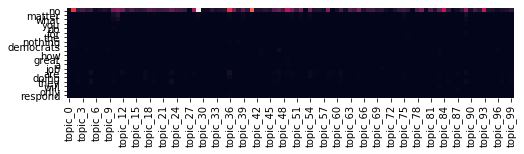

In [16]:
plt.subplots(figsize=(8,8))
_= sns.heatmap(components.head(20), square=True, cbar=False)

Let's inspect the topics to see if we can find any hostile topics. Keep in mind that although the scores seem very similar 
betweet topics. there are subtle differences.

In [17]:
for col in components.columns:
    print(col)
    print()
    output = components[col].sort_values(ascending=False).head(10)
    print(output)
    print()
    print('---------------------------------------------------------')

topic_0

especially since    7.01
lots                6.01
( monday            5.01
home from           4.01
. dems were         4.01
mom and             4.01
kingdom . it        3.01
no                  3.01
see tim ,           3.01
to working          2.01
Name: topic_0, dtype: float64

---------------------------------------------------------
topic_1

home from           77.811018
. dems were         67.964748
especially since    50.969216
but pretended to    47.571984
no                  45.597875
innocent she        44.102317
( monday            40.492832
’ s meetings        35.950355
the right thing     35.132277
lots                31.664768
Name: topic_1, dtype: float64

---------------------------------------------------------
topic_2

. dems were         37.646310
( monday            35.884197
especially since    31.872417
home from           24.455054
leaving fast        23.209519
lots                13.547774
no                  11.767621
me again            10.737437
wants

. dems were         28.553704
( monday            26.123493
especially since    20.107190
no                  14.033119
travelers “         12.022989
home from           11.574875
lots                10.543007
ndaa                 9.656295
leaving fast         9.641243
thing if             8.862161
Name: topic_25, dtype: float64

---------------------------------------------------------
topic_26

( monday            50.697957
especially since    38.643694
. dems were         38.433659
home from           17.843132
leaving fast        17.106252
wants to be         15.175770
no                  12.128840
industry will be    11.939763
ndaa                11.832939
me again            11.242497
Name: topic_26, dtype: float64

---------------------------------------------------------
topic_27

in stockpile !            0.01
a connection between      0.01
between the assistance    0.01
the assistance and        0.01
assistance and the        0.01
and the investigation     0.01
the investigat

Name: topic_46, dtype: float64

---------------------------------------------------------
topic_47

( monday            58.672378
. dems were         54.356826
especially since    54.140366
home from           29.329518
lots                24.292562
me again            20.994172
no                  20.853606
industry will be    18.908824
much fake news      17.146970
ndaa                15.327972
Name: topic_47, dtype: float64

---------------------------------------------------------
topic_48

especially since    34.599066
( monday            24.415322
. dems were         22.714453
no                  13.092344
, said that         12.009188
leaving fast        10.195866
me again             9.987378
travelers “          8.937122
home from            8.864957
the right thing      7.950521
Name: topic_48, dtype: float64

---------------------------------------------------------
topic_49

especially since    110.982696
. dems were          82.541259
( monday             58.743959
home fr

Name: topic_75, dtype: float64

---------------------------------------------------------
topic_76

especially since    22.931577
( monday            20.506430
. dems were         19.321349
lots                12.627875
home from           10.929479
wants to be         10.519309
no                  10.379126
abuse of power      10.179576
invigorating         7.456706
an email from        7.456674
Name: topic_76, dtype: float64

---------------------------------------------------------
topic_77

home from           5.01
especially since    4.01
. dems were         3.01
abuse of power      2.01
at the united       2.01
leaving fast        2.01
the right thing     2.01
ve ever seen        2.01
taxes and energy    2.01
, gianna ,          2.01
Name: topic_77, dtype: float64

---------------------------------------------------------
topic_78

. dems were         44.948370
( monday            44.289783
especially since    36.241147
home from           32.616911
wants to be         17.204045


So, that's some interesting visibility into the topics. That's one very nice thing about LDiA. So, now, onto prediction.

But first, let's make the topic vectors for use in prediction.

In [20]:
topic_vectors = ldia.transform(bow_docs)
#topic_vectors = ldia.transform(tfidf_docs)

columns = ['topic_{}'.format(i) for i in range(ldia.n_components)]
topic_vectors = pd.DataFrame(topic_vectors, columns=columns)
topic_vectors.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
0,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,...,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051
1,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,...,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055
2,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,...,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055
3,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,...,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058
4,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,...,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054


# Hostile Classification

This part is a work in progress. Get ideas from this guide and possibly re-read the chapter from the book.
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [21]:
X = topic_vectors
y = labels

X.shape, y.shape

((1432, 100), (1432,))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.5)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((716, 100), (716, 100), 716, 716)

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train, y_train)
lda.score(X_train, y_train), lda.score(X_test, y_test)

# (0.6731843575418994, 0.5279329608938548) - bow w/o stopwords
# (0.6871508379888268, 0.5572625698324022) - bow w/ all characters w/o stopwords
# (0.6885474860335196, 0.5502793296089385) - bow w/ all characters and all stopwords
# (0.6871508379888268, 0.5502793296089385) - more ldia runs... so doesn't improve. moving on


# (0.6620111731843575, 0.5544692737430168) - tfidf w/o stopwords
# (0.6564245810055865, 0.5614525139664804) - tfidf w/ all characters w/o stopwords
# (0.7262569832402235, 0.6075418994413407) - tfidf w/ all characters and all stopwords

(0.6871508379888268, 0.5502793296089385)

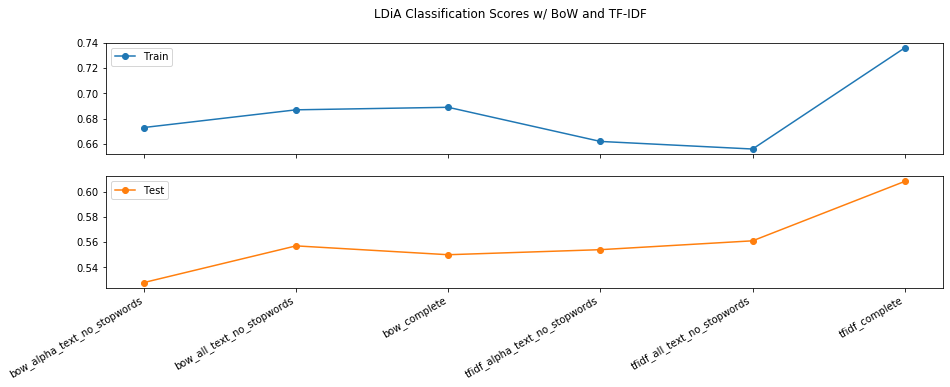

In [53]:
bow_1 = [0.673, 0.528]
bow_2 = [0.687, 0.557]
bow_3 = [0.689, 0.550]

tfidf_1 = [0.662, 0.554]
tfidf_2 = [0.656, 0.561]
tfidf_3 = [0.736, 0.608]

res_df = pd.DataFrame({'1':bow_1, '2':bow_2, '3':bow_3, '4':tfidf_1, '5':tfidf_2, '6':tfidf_3})
res_df.columns = ['bow_alpha_text_no_stopwords', 'bow_all_text_no_stopwords', 'bow_complete',
                 'tfidf_alpha_text_no_stopwords', 'tfidf_all_text_no_stopwords', 'tfidf_complete']
res_df = res_df.T
res_df.columns = ['Train', 'Test']
_= res_df.plot(figsize=(15,5), marker='o', title='LDiA Classification Scores w/ BoW and TF-IDF', subplots=True)

# Topic Modeling with TruncatedSVD

In [29]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, n_iter=100, random_state=1337)
#svd_topic_vectors = svd.fit_transform(bow_docs)
svd_topic_vectors = svd.fit_transform(tfidf_docs)

In [30]:
X = svd_topic_vectors
y = labels

X.shape, y.shape

((1432, 100), (1432,))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.5)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((716, 100), (716, 100), 716, 716)

In [32]:
lda = LDA(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train, y_train)
lda.score(X_train, y_train), lda.score(X_test, y_test)

# (0.8729050279329609, 0.8337988826815642) - bow w/ all characters and all stopwords
# (0.909217877094972, 0.8980446927374302) - tfidf w/ all characters and 

(0.909217877094972, 0.8980446927374302)

In [39]:
topic_df = pd.DataFrame(X).merge(labels, left_index=True, right_index=True)
topic_df_0 = topic_df[topic_df['label']==0].iloc[:,0:100]
topic_df_1 = topic_df[topic_df['label']==1].iloc[:,0:100]

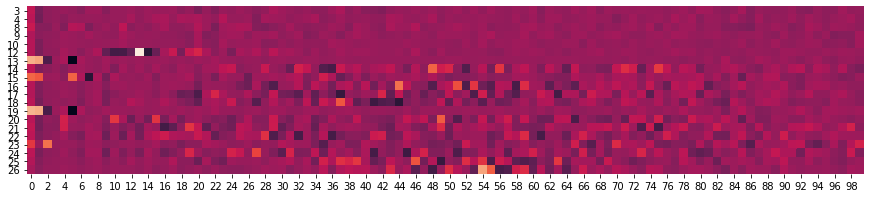

In [50]:
plt.subplots(figsize=(15,5))
_= sns.heatmap(topic_df_0.head(20), cbar=False, square=True)

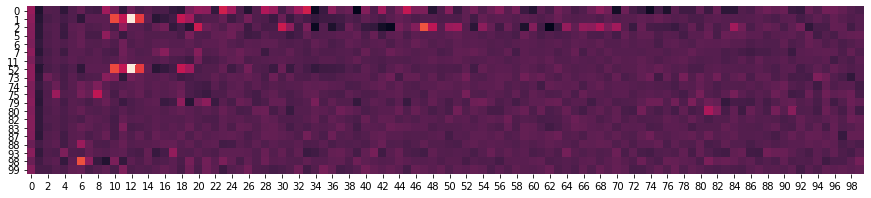

In [51]:
plt.subplots(figsize=(15,5))
_= sns.heatmap(topic_df_1.head(20), cbar=False, square=True)

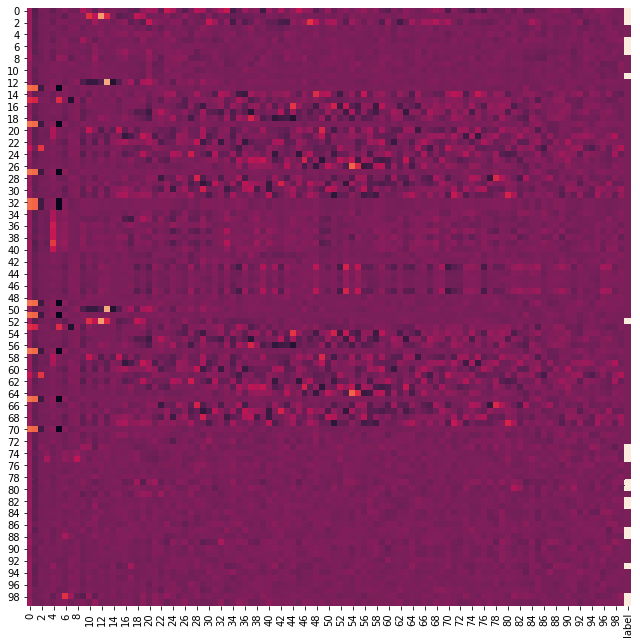

In [59]:
plt.subplots(figsize=(11,11))
_= sns.heatmap(topic_df.head(100), cbar=False, square=True)